<a href="https://colab.research.google.com/github/KoSeoAh/ML_2022/blob/main/1)_%EA%B0%90%EC%84%B1%EC%82%AC%EC%A0%84_%EC%BD%94%EB%93%9C_%EA%B8%B0%EC%A3%BC%EB%8B%98%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# bash로 명령어 입력하여 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 167 kB in 2s (79.3 kB/s)
Reading package l

In [ ]:
# 환경변수 설정
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
# Mecab 설치
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141802 sha256=e507eead05a86df600eda81d73e180e9c55217ad5bd2ad9b7c8eb2e36b11081f
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from vega_datasets import data
import seaborn as sns
from datetime import datetime
import os
from tqdm import tqdm
import re

import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') 
mpl.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontcon

# 데이터 전처리

In [ ]:
# 뉴스가 투자자의 감성에 어떻게 영향을 미치는지 알아보기 위해 response variable로 수익률 사용

trading = pd.read_csv('/content/drive/MyDrive/ML/000270.KS.csv')
trading = trading[['Date', 'Adj Close']]
trading = trading.rename(columns={'Adj Close':'Price'})
trading = trading.set_index('Date')
trading.index = pd.to_datetime(trading.index)
trading = trading.astype('float')
trading.dropna(inplace=True)
trading = np.log(trading) - np.log(trading.shift(1))
trading = trading.loc['2017-04-01':'2021-08-08']
trading = trading.sort_index(ascending=True)
trading

,Price
Date,
2017-04-03,-0.005413
2017-04-04,-0.013662
2017-04-05,-0.011065
2017-04-06,-0.002785
2017-04-07,-0.008403
...,...
2021-08-02,0.013072
2021-08-03,0.012903
2021-08-04,0.013889


In [ ]:
# 뉴스 데이터 불러오기 

doc = pd.read_csv('/content/drive/MyDrive/ML/최종 뉴스데이터.csv')
doc

,날짜,제목
0,2017.04.01,"버나디나 10회 결승타… 기아타이거즈, 삼성에 진땀승 '2연승'"
1,2017.04.01,[2017 서울모터쇼]기아차 스팅어… 새 엠블럼의 의미는?
2,2017.04.01,기아타이거즈 프로야구 첫 연장승
3,2017.04.01,"나지완 멀티홈런...기아, 개막전 승리"
4,2017.04.01,[기아VS삼성] 기아의 7:3리드…삼성 최경철의 쓰리런으로 0점 패배 면해
...,...,...
1302919,2021.08.08,"[올림픽]펜싱 은메달 강영미, 12일 KIA-한화전 시구자 초청"
1302920,2021.08.08,"도쿄올림픽 펜싱 은메달 강영미, 12일 광주 KIA-한화전 시구"
1302921,2021.08.08,"'도쿄올림픽 펜싱 은메달' 강영미, 12일 KIA 홈경기 시구"
1302922,2021.08.08,도쿄올림픽 은메달리스트 강영미 시구


In [ ]:
doc.drop_duplicates(inplace=True)
doc

,날짜,제목
0,2017.04.01,"버나디나 10회 결승타… 기아타이거즈, 삼성에 진땀승 '2연승'"
1,2017.04.01,[2017 서울모터쇼]기아차 스팅어… 새 엠블럼의 의미는?
2,2017.04.01,기아타이거즈 프로야구 첫 연장승
3,2017.04.01,"나지완 멀티홈런...기아, 개막전 승리"
4,2017.04.01,[기아VS삼성] 기아의 7:3리드…삼성 최경철의 쓰리런으로 0점 패배 면해
...,...,...
1302919,2021.08.08,"[올림픽]펜싱 은메달 강영미, 12일 KIA-한화전 시구자 초청"
1302920,2021.08.08,"도쿄올림픽 펜싱 은메달 강영미, 12일 광주 KIA-한화전 시구"
1302921,2021.08.08,"'도쿄올림픽 펜싱 은메달' 강영미, 12일 KIA 홈경기 시구"
1302922,2021.08.08,도쿄올림픽 은메달리스트 강영미 시구


In [ ]:
# 날짜 별로 뉴스 데이터 헤드라인 모으기

dates = doc.날짜.unique() # 날짜 리스트 생성

merge = [] #정보 저장할 리스트
for date in dates: # 날짜 하나 당
    data = doc[doc['날짜'] == date]['제목'].values.tolist() # 날짜에 해당하는 headline 정보 전부 불러온 후 list로 변경
    headlines = ' '.join(str(x) for x in data) # list 정보 하나하나 string으로 변경한 후 join을 통해 하나의 string으로 변경
    merge.append([date, headlines]) # 리스트에 저장
    
merge_df = pd.DataFrame(merge, columns = ['날짜', '제목']) # Dataframe으로 변환
merge_df = merge_df.rename(columns={'날짜':'Date', '제목':'Article'})
merge_df = merge_df.set_index('Date')
doc = merge_df
doc

,Article
Date,
2017.04.01,"버나디나 10회 결승타… 기아타이거즈, 삼성에 진땀승 '2연승' [2017 서울모터..."
2017.04.02,"현대기아차 할부 최고금리 7.9%→4.5% 파격인하 현대·기아차, 지난해 연구개발비..."
2017.04.03,"기아차, '2018 카니발' 출시 본격 판매 기아차, 3월 해외·내수 판매 `울상`..."
2017.04.04,"현대기아차, 6개 차종 獨 레드닷 디자인상 수상 현대·기아차 미국 판매 11% 뚝 ..."
2017.04.05,"""적자 인정·대신 기부금 30억"" 기아 챔피언스 필드 운영권 결론 기아차 직원 평균..."
...,...
2021.08.04,"美 홀린 현대차·기아…제네시스, 3개월째 판매 신기록 행진 반도체 대란 뚫고…현대차..."
2021.08.05,"현대차·기아, 美서 친환경차 판매 `질주`‥전년比 200% 급증 車도 작품이다! 기..."
2021.08.06,"美 ""2030년까지 신차 50% 전기차""…현대차·기아도 지지성명 그랜저 월 판매량 ..."


In [ ]:
# 뉴스 데이터 날짜 & 순매수대금 날짜 일치 시키기

doc.index = pd.to_datetime(doc.index)

tmp = pd.concat([doc, trading], axis=1)
tmp.dropna(inplace=True)

doc = tmp.drop('Price', axis=1)
doc

,Article
Date,
2017-04-03,"기아차, '2018 카니발' 출시 본격 판매 기아차, 3월 해외·내수 판매 `울상`..."
2017-04-04,"현대기아차, 6개 차종 獨 레드닷 디자인상 수상 현대·기아차 미국 판매 11% 뚝 ..."
2017-04-05,"""적자 인정·대신 기부금 30억"" 기아 챔피언스 필드 운영권 결론 기아차 직원 평균..."
2017-04-06,기아차광주공장 독거노인 가구에 사랑 배달 기아차 2018년형 모하비 출시…맞춤형 사...
2017-04-07,"현대기아, 미국서 119만대 리콜 확정…캐나다는 11만대 협의(종합) 현대기아차, ..."
...,...
2021-08-02,"기아, 7월 24만1399대 판매…해외 10.4% 증가 '사전예약 돌풍' 기아 EV..."
2021-08-03,"현대차·기아·벤츠·BMW '4강체제'…'르쌍쉐' 밀려나 현대차·기아, 반도체 대란 ..."
2021-08-04,"美 홀린 현대차·기아…제네시스, 3개월째 판매 신기록 행진 반도체 대란 뚫고…현대차..."


# 감성사전 구축

In [ ]:
# 형태소 분석 - 명사만 추출

mecab = Mecab()

content = np.array(doc.Article)
news = np.array([' '.join(mecab.nouns(sent)) for sent in content])
cont = np.array([re.sub('[^a-zA-Zㄱ-ㅣ가-힣]', ' ', dat) for dat in news])

In [ ]:
kia_news = pd.DataFrame(cont)
kia_news.index = doc.index
kia_news = kia_news.rename(columns={0:'Noun'})
kia_news

,Noun
Date,
2017-04-03,기아차 카니발 출시 본격 판매 기아차 월 해외 내수 판매 울상 전년 르노삼성 월 약...
2017-04-04,현대 기아차 개 차종 레드 닷 디자인 수상 현대 기아차 미국 판매 뚝 현대 기아...
2017-04-05,적자 인정 대신 기부금 억 기아 챔피 언스 필드 운영 결론 기아차 직원 평균 근속 ...
2017-04-06,기아차 광주 공장 독거 노인 가구 사랑 배달 기아차 년 모하 출시 맞춤 사양 추가 ...
2017-04-07,현대 기아 미국 만 대 리콜 확정 캐나다 만 대 협의 종합 현대 기아차 세타 엔진 ...
...,...
2021-08-02,기아 월 만 대 판매 해외 증가 사전 예약 돌풍 기아 출시 가격 천 만 원 기아 전...
2021-08-03,현대차 기아 벤츠 강 체제 르 쌍 쉐 현대차 기아 반도체 대란 친환경 차 판매 기아...
2021-08-04,현대차 기아 제네시스 개월 판매 신기록 행진 반도체 대란 현대차 기아 현대차...


In [ ]:
kia_news.to_csv('/content/drive/MyDrive/ML/날짜별 기사.csv')

In [ ]:
# 감성사전 구축을 위해 단어별로 TF-IDF 값 학습
# 단어들의 중요도를 타나내는 TF-IDF 행렬 도출

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=200) # 단어의 차원 수 조절
tfidf_vectorizer.fit(cont)
col = sorted(tfidf_vectorizer.vocabulary_.items())
word = [w[0] for w in col]
text = pd.DataFrame(tfidf_vectorizer.transform(news).toarray(), columns=word)
text.index = doc.index

In [ ]:
text.index = pd.to_datetime(text.index)
text

,가격,가능,가동,가속,가솔린,가정,가족,가지,가치,갈등,...,회사,회장,효과,후보,후원,후퇴,훈풍,흥행,희망,희비
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-03,0.014717,0.009982,0.008000,0.013378,0.0,0.0,0.0,0.008829,0.000000,0.000000,...,0.000000,0.011936,0.052576,0.000000,0.000000,0.000000,0.000000,0.018225,0.028065,0.030020
2017-04-04,0.003201,0.006513,0.005219,0.008728,0.0,0.0,0.0,0.005761,0.000000,0.005266,...,0.000000,0.003894,0.007623,0.000000,0.000000,0.000000,0.000000,0.011891,0.004578,0.000000
2017-04-05,0.007199,0.007324,0.011739,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.008758,0.000000,0.026589,0.023718,0.000000,0.000000,0.026745,0.010296,0.014684
2017-04-06,0.034301,0.004985,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.005961,0.000000,0.009049,0.016145,0.010529,0.000000,0.000000,0.007008,0.000000
2017-04-07,0.001867,0.005697,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.002223,0.003447,0.003075,0.004011,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,0.037961,0.007022,0.000000,0.004705,0.0,0.0,0.0,0.018633,0.000000,0.000000,...,0.000000,0.008397,0.012328,0.000000,0.000000,0.007415,0.000000,0.006410,0.004936,0.007039
2021-08-03,0.033942,0.034532,0.000000,0.000000,0.0,0.0,0.0,0.015272,0.000000,0.000000,...,0.000000,0.010323,0.000000,0.000000,0.000000,0.000000,0.000000,0.031525,0.000000,0.017308
2021-08-04,0.000000,0.014698,0.047117,0.009849,0.0,0.0,0.0,0.000000,0.022531,0.000000,...,0.000000,0.000000,0.025806,0.000000,0.000000,0.000000,0.031559,0.000000,0.000000,0.000000


In [ ]:
# 수익률 추가하여 최종 데이터셋 완성

trading = trading.shift(1)

df = pd.concat([trading, text], axis=1)
df.drop('2017-04-03', inplace=True)
df

,Price,가격,가능,가동,가속,가솔린,가정,가족,가지,가치,...,회사,회장,효과,후보,후원,후퇴,훈풍,흥행,희망,희비
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-04,-0.005413,0.003201,0.006513,0.005219,0.008728,0.0,0.0,0.000000,0.005761,0.000000,...,0.000000,0.003894,0.007623,0.000000,0.000000,0.000000,0.000000,0.011891,0.004578,0.000000
2017-04-05,-0.013662,0.007199,0.007324,0.011739,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.008758,0.000000,0.026589,0.023718,0.000000,0.000000,0.026745,0.010296,0.014684
2017-04-06,-0.011065,0.034301,0.004985,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.005961,0.000000,0.009049,0.016145,0.010529,0.000000,0.000000,0.007008,0.000000
2017-04-07,-0.002785,0.001867,0.005697,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.002223,0.003447,0.003075,0.004011,0.000000,0.000000,0.000000,0.000000
2017-04-10,-0.008403,0.023252,0.005914,0.000000,0.031704,0.0,0.0,0.021885,0.000000,0.000000,...,0.000000,0.000000,0.006922,0.000000,0.028728,0.000000,0.012698,0.010798,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,-0.031786,0.037961,0.007022,0.000000,0.004705,0.0,0.0,0.000000,0.018633,0.000000,...,0.000000,0.008397,0.012328,0.000000,0.000000,0.007415,0.000000,0.006410,0.004936,0.007039
2021-08-03,0.013072,0.033942,0.034532,0.000000,0.000000,0.0,0.0,0.000000,0.015272,0.000000,...,0.000000,0.010323,0.000000,0.000000,0.000000,0.000000,0.000000,0.031525,0.000000,0.017308
2021-08-04,0.012903,0.000000,0.014698,0.047117,0.009849,0.0,0.0,0.000000,0.000000,0.022531,...,0.000000,0.000000,0.025806,0.000000,0.000000,0.000000,0.031559,0.000000,0.000000,0.000000


# Ridge Regression

개인투자자의 순매수대금에 미치는 영향력 회귀 계수로 파악

## Preprocessing

In [ ]:
X = df.drop(columns=['Price'])
y = df['Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# 같은 스케일로 맞추기 위해 standardizing

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Z_train = ss.fit_transform(X_train) # Fit 
Z_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns, index=X_train.index) # Transform the df

In [ ]:
Z_train.head()

,가격,가능,가동,가속,가솔린,가정,가족,가지,가치,갈등,...,회사,회장,효과,후보,후원,후퇴,훈풍,흥행,희망,희비
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-29,0.011688,0.559206,-0.029648,-0.620016,-0.199599,0.362598,-0.275883,0.763593,-0.266483,-0.466364,...,-0.429783,-0.396927,-0.105971,-0.301530,1.717118,-0.352516,1.147595,-0.417089,-0.454739,-0.411578
2021-07-23,-0.564309,-0.415931,-0.341482,-0.620016,-0.199599,-0.242388,-0.275883,0.391760,-0.266483,0.135133,...,-0.151339,8.392221,-0.097583,-0.116214,-0.309669,-0.352516,-0.344681,-0.417089,-0.285252,-0.411578
2017-10-31,-0.472312,-0.513635,-0.341482,-0.245302,-0.199599,-0.242388,-0.011768,-0.387102,-0.266483,3.085457,...,-0.064404,-0.298352,-0.410849,-0.301530,-0.181086,-0.352516,2.968878,-0.417089,-0.232336,-0.411578
2018-07-27,-0.371536,0.553258,-0.341482,-0.305097,-0.199599,-0.242388,-0.275883,-0.387102,-0.266483,-0.466364,...,-0.429783,-0.314082,0.369054,-0.301530,-0.309669,-0.352516,-0.344681,-0.417089,-0.454739,0.241529
2020-08-21,-0.621141,-0.700044,-0.341482,-0.620016,-0.199599,-0.242388,-0.275883,0.241535,-0.106544,-0.466364,...,-0.429783,-0.275664,-0.654407,-0.002385,-0.309669,-0.352516,0.470565,-0.417089,0.366038,-0.411578


## Modeling

In [ ]:
from sklearn.linear_model import Ridge

Ridge의 회귀계수에 대한 영향 시각화

In [ ]:
def ridge_coefs(X, y, alphas):
    
    coefs = [] # List of coefficients:
    ridge_reg = Ridge() # Initiate the model
    
    for a in alphas: # Iterate through the alphas fed into the function:
        ridge_reg.set_params(alpha=a) # Reinitiate with the new alpha:
        ridge_reg.fit(X, y) # Refit the model on the provided X, y
        coefs.append(ridge_reg.coef_) # Print the coefficient list
        
    return coefs

In [ ]:
r_alphas = np.logspace(0, 5, 200) # 로그 공간의 난수 생성. 베이스는 10.
r_coefs = ridge_coefs(Z_train, y_train, r_alphas) # Ridge에 대해 각 알파의 계수 저장

In [ ]:
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]

    colors = sns.color_palette("husl", len(coefs[0]))
    fig = plt.figure()
    fig.set_size_inches(18,5)

    ax1 = fig.add_subplot(121)
    ax1.set_prop_cycle(cycler('color', colors))
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax1.plot(alphas, coefs, lw=2)
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    
    ax1.set_xlim([amin, amax]) # Enforce the axis limits
    ax1.set_title(regtype+' coefficients\n', fontsize=20) # Put a title on the axis
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the second chart:
    ymin, ymax = ax1.get_ylim()

    ax2 = fig.add_subplot(122)
    ax2.bar(list(range(1, len(feature_names)+1)), coefs[-1], align='center', color=colors)
    ax2.set_xticks(list(range(1, len(feature_names)+1)))
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefficients\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()

In [ ]:
from ipywidgets import *
from IPython.display import display

def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, X.columns, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.1,5,0.2))
print("this snippet is taken from an online source") # (좌) Regularization path, (우) 알파에 따른 계수

interactive(children=(FloatSlider(value=0.1, description='log_of_alpha', max=5.0, min=0.1, step=0.2), Output()…

this snippet is taken from an online source



*   알파(regularization coefficient의 strength)와 계수 사이의 관계를 볼 수 있음.
*   최적의 알파값을 찾는 것은 cross-validation을 통해서 가장 큰 알파값을 가진 모델을 선택.



In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV

In [ ]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100) # Generates 200 values equally between 0 and 5, then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2') # Ridge-alphas에 대한 cross-validation

ridge_model = ridge_model.fit(Z_train, y_train)

In [ ]:
# 최적의 알파값
ridge_optimal_alpha = ridge_model.alpha_
ridge_optimal_alpha

9770.099572992247

In [ ]:
Z_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

In [ ]:
ridge_opt = Ridge(alpha=ridge_optimal_alpha)
ridge_opt.fit(Z_train, y_train)

# Generate predictions
ridge_opt_preds = ridge_opt.predict(Z_test)
ridge_opt_preds_train = ridge_opt.predict(Z_train)

# Evaluate model
print(r2_score(y_test, ridge_opt_preds))
print(r2_score(y_train, ridge_opt_preds_train))

0.022541216478210613
0.14276553071870968




*   높지 않은 $R^2$ 값을 보임. 
*   시계열 데이터 전처리(trend, seasonality, noise 제거)를 하지 않았기 때문인지, 선형회귀모형의 assumptions이 violated가 되었는지, 혹은 다른 이유 때문인지 추가적인 확인이 필요함.
* 다만, 전체 데이터로 구축한 모델이 아니기에 추후 전체 데이터로 다시 fitting 하면 더 높은 $R^2$ 값을 보일 수 있을 거라 예측.



# 최종 감성점수 도출

In [ ]:
coeff = pd.Series(data=ridge_opt.coef_, index=X.columns)
coeff_df = pd.DataFrame(coeff)
coeff_df.columns = ['감성점수']
coeff_df

,감성점수
가격,0.000012
가능,0.000067
가동,-0.000071
가속,0.000027
가솔린,-0.000020
...,...
후퇴,-0.000019
훈풍,-0.000022
흥행,-0.000045
희망,-0.000035


In [ ]:
coeff_df.sort_values('감성점수', ascending=False)

,감성점수
기대감,0.000250
검토,0.000217
플랫,0.000212
차세대,0.000206
급등,0.000181
...,...
여성,-0.000140
극복,-0.000143
사장,-0.000186
라인업,-0.000192


In [ ]:
coeff_df = coeff_df * 10000
coeff_df.sort_values('감성점수', ascending=False)

,감성점수
기대감,2.497709
검토,2.167131
플랫,2.120899
차세대,2.063997
급등,1.807435
...,...
여성,-1.395190
극복,-1.433442
사장,-1.862667
라인업,-1.921504


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


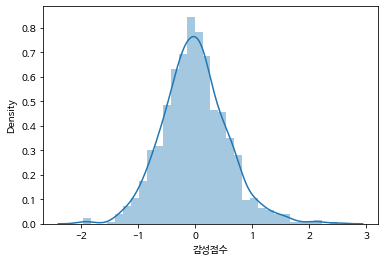

In [ ]:
sns.distplot(coeff_df['감성점수'])

In [ ]:
coeff_df.to_csv('/content/drive/MyDrive/ML/최종 감성사전.csv', index=True)